## Problem: Detection of aggressive tweets

Training dataset has 12776 tweets (in english) and validation dataset has 3194 tweets.<br/>
Tweets are labeled (by human) as:
* 1 (Cyber-Aggressive)
* 0 (Non Cyber-Aggressive)

# Classification of Tweets

## Data

In [1]:
import pandas as pd
import numpy as np

In [2]:
data_train = pd.read_json('./Data/train.json')
data_valid = pd.read_json('./Data/valid.json')

In [3]:
X_train = data_train.content
y_train = data_train.label
X_test = data_valid.content
y_test = data_valid.label

## Preprocessing

In [5]:
import nltk
import re

from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from mytextpreprocessing import TextPreprocessor
from mytextpreprocessing import FrequencyExtractor
from mytextpreprocessing import SimilarityToAggressiveTweets
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve

from myutils import *

In [5]:
# nltk.download()

In [6]:
def print_accuracy(pipe, X):
    pipe.fit(X, y_train);

    y_train_pred = pipe.predict(X)
    y_test_pred = pipe.predict(X_test)

    print('Tarining dataset: accuracy = %.3f' % accuracy_score(y_pred=y_train_pred, y_true=y_train))
    print('Test dataset: accuracy = %.3f' % accuracy_score(y_pred=y_test_pred, y_true=y_test))

Additional features give some infromation (the accuracy is higher than the contribution of class 0)

In [7]:
print('Train: {:.4f}'.format(1 - y_train.mean()))
print('Test: {:.4f}'.format(1 - y_test.mean()))

Train: 0.6032
Test: 0.6183


In [8]:
test_pipe = Pipeline([('feats', FrequencyExtractor()),
                      ('clf', LogisticRegression(penalty='l2', C=1.0))
                     ])

print_accuracy(test_pipe, X_train)

Tarining dataset: accuracy = 0.608
Test dataset: accuracy = 0.628


Text normalization does not improve the results

In [6]:
token_pattern = '(?u)\\b[a-z][a-z\'*]+\\b'

In [10]:
test_pipe = Pipeline([('vectorizer', CountVectorizer(token_pattern=token_pattern)),
                      ('scaler', MaxAbsScaler()),
                      ('clf', LogisticRegression(penalty='l2', C=1.0))])

print_accuracy(test_pipe, X_train)
print('============================================')
X_train_normalized = TextPreprocessor().fit_transform(X_train)
print_accuracy(test_pipe, X_train_normalized)

Tarining dataset: accuracy = 0.924
Test dataset: accuracy = 0.816
Tarining dataset: accuracy = 0.923
Test dataset: accuracy = 0.810


In [11]:
test_pipe = Pipeline([('vectorizer', CountVectorizer(token_pattern=token_pattern, ngram_range=(1, 2))),
                      ('scaler', MaxAbsScaler()),
                      ('clf', LogisticRegression(penalty='l2', C=1.0))])

print_accuracy(test_pipe, X_train)
print('============================================')
X_train_normalized = TextPreprocessor().fit_transform(X_train)
print_accuracy(test_pipe, X_train_normalized)

Tarining dataset: accuracy = 0.988
Test dataset: accuracy = 0.887
Tarining dataset: accuracy = 0.992
Test dataset: accuracy = 0.877


Text normalization is useful to reduce number of fetures

In [7]:
STOPWORDS = nltk.corpus.stopwords.words('english')
IRRELEVANT_STOPWORDS = list(pd.read_csv('./Data/irrelevant_stopwords.csv', header=None)[0].values)

In [13]:
dtm = CountVectorizer(token_pattern=token_pattern).fit_transform(X_train)

print('Number of features: %i' % dtm.shape[1])
inds = np.argwhere(dtm.sum(axis=0) == 1)[:, 1]
print('Number of single words: %i' % inds.shape[0])
print('Ratio = %.3f' % (inds.shape[0] / dtm.shape[1],))

Number of features: 13231
Number of single words: 6344
Ratio = 0.479


In [14]:
# normalization
test_pipe = Pipeline([('preprocessor', TextPreprocessor(process='', 
                                                        stopwords=[])),
                      ('vectorizer', CountVectorizer(token_pattern=token_pattern))])
dtm = test_pipe.fit_transform(X_train)

print('Number of features: %i' % dtm.shape[1])
inds = np.argwhere(dtm.sum(axis=0) == 1)[:, 1]
print('Number of single words: %i' % inds.shape[0])
print('Ratio = %.3f' % (inds.shape[0] / dtm.shape[1],))

Number of features: 12749
Number of single words: 6004
Ratio = 0.471


In [15]:
# normalization + stemming
test_pipe = Pipeline([('preprocessor', TextPreprocessor(process='stem', 
                                                        stopwords=IRRELEVANT_STOPWORDS)),
                      ('vectorizer', CountVectorizer(token_pattern=token_pattern))])
dtm = test_pipe.fit_transform(X_train)

print('Number of features: %i' % dtm.shape[1])
inds = np.argwhere(dtm.sum(axis=0) == 1)[:, 1]
print('Number of single words: %i' % inds.shape[0])
print('Ratio = %.3f' % (inds.shape[0] / dtm.shape[1],))

Number of features: 9933
Number of single words: 4435
Ratio = 0.446


In [16]:
# normalization + lemmatization
test_pipe = Pipeline([('preprocessor', TextPreprocessor(process='lem', 
                                                        stopwords=IRRELEVANT_STOPWORDS)),
                      ('vectorizer', CountVectorizer(token_pattern=token_pattern))])
dtm = test_pipe.fit_transform(X_train)

print('Number of features: %i' % dtm.shape[1])
inds = np.argwhere(dtm.sum(axis=0) == 1)[:, 1]
print('Number of single words: %i' % inds.shape[0])
print('Ratio = %.3f' % (inds.shape[0] / dtm.shape[1],))

Number of features: 10951
Number of single words: 5205
Ratio = 0.475


In [17]:
np.array(test_pipe.named_steps['vectorizer'].get_feature_names())[inds][:150]

array(["a's", 'aa', 'aaron', 'aaronage', 'aawwhh', 'ab', 'abandon',
       'abcdefghijklmnopqrstuvwxyz', 'abducted', 'abide', 'aboard',
       'abou', 'abouht', 'aboutt', 'abraham', 'abrams', 'absess',
       'absolute', 'abundance', 'ac', 'acai', 'accommodate', 'accomplish',
       'accomplishment', 'accountability', 'accountable', 'accountt',
       'accpet', 'accumulate', 'accuracy', 'accurately', 'accuse',
       'achingly', 'ack', 'acne', 'acoustic', 'acronym', 'activesync',
       'activist', 'activity', 'actualy', 'actvities', 'acutely',
       'adangta', 'adapt', 'adchifying', 'addies', 'adedd', 'adidas',
       'adium', 'administration', 'adonis', 'adriane', 'adrianne',
       'adtrotrain', 'advertising', 'adverts', 'aeongotbeats', 'aerial',
       'aerodynamic', 'affligem', 'afl', 'afriad', 'african', 'afro',
       'aft', 'aftermath', 'afterparty', 'again', 'agency', 'aggress',
       'aggressive', 'agh', 'agin', 'agreat', 'ahaa', 'ahaah', 'ahhaaha',
       'ahve', 'aight', 

## Advanced (baseline) model

### LogisticRegression

In [18]:
# stemming
stem_pipe = Pipeline([
    ('features', FeatureUnion([
            ('numerical_feats', FrequencyExtractor()),    
            ('text_feats', Pipeline([('preprocessor', TextPreprocessor(stopwords=IRRELEVANT_STOPWORDS, 
                                                                       process='stem')),
                                     ('vectorizer', CountVectorizer(token_pattern=token_pattern, min_df=2))
                                    ]))
            ])),
    ('scaler', MaxAbsScaler())
    ])

In [19]:
X_train_stem_preprocessed = stem_pipe.fit_transform(X_train)
X_test_stem_preprocessed = stem_pipe.transform(X_test)

In [20]:
'n\'t' in stem_pipe.named_steps['features'].transformer_list[1][1].named_steps['vectorizer'].vocabulary_

False

In [21]:
'don\'t' in stem_pipe.named_steps['features'].transformer_list[1][1].named_steps['vectorizer'].vocabulary_

True

In [22]:
'f*cker' in stem_pipe.named_steps['features'].transformer_list[1][1].named_steps['vectorizer'].vocabulary_

True

In [23]:
stem_lr_model = LogisticRegression(penalty='l2', C=1.0)
stem_lr_model.fit(X_train_stem_preprocessed, y_train);

y_train_pred = stem_lr_model.predict(X_train_stem_preprocessed)
y_test_pred = stem_lr_model.predict(X_test_stem_preprocessed)

print('Tarining dataset: accuracy = %.3f' % accuracy_score(y_pred=y_train_pred, y_true=y_train))
print('Test dataset: accuracy = %.3f' % accuracy_score(y_pred=y_test_pred, y_true=y_test))

Tarining dataset: accuracy = 0.883
Test dataset: accuracy = 0.784


In [24]:
y_train_proba = stem_lr_model.predict_proba(X_train_stem_preprocessed)[:, 1]
y_test_proba = stem_lr_model.predict_proba(X_test_stem_preprocessed)[:, 1]
print('Tarining dataset: accuracy = %.3f' % roc_auc_score(y_score=y_train_proba, y_true=y_train))
print('Test dataset: accuracy = %.3f' % roc_auc_score(y_score=y_test_proba, y_true=y_test))

Tarining dataset: accuracy = 0.952
Test dataset: accuracy = 0.860


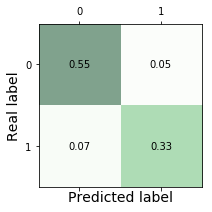

In [25]:
plot_confusion_matrix(y_train, y_train_pred)

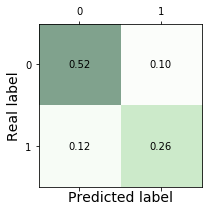

In [26]:
plot_confusion_matrix(y_test, y_test_pred)

The model seems to be overfitted

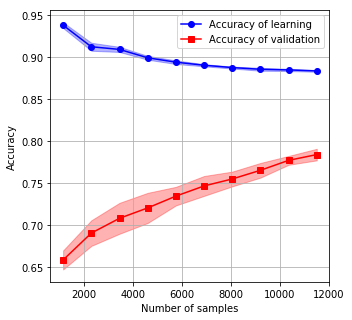

In [27]:
plot_learning_curve(estimator=stem_lr_model, X=X_train_stem_preprocessed, y=y_train)

In [28]:
# lemmatization
lem_pipe = Pipeline([
    ('features', FeatureUnion([
            ('numerical_feats', FrequencyExtractor()),    
            ('text_feats', Pipeline([('preprocessor', TextPreprocessor(stopwords=IRRELEVANT_STOPWORDS, 
                                                                       process='lem')),
                                     ('vectorizer', CountVectorizer(token_pattern=token_pattern, min_df=2))
                                    ]))
            ])),
    ('scaler', MaxAbsScaler())
    ])

In [29]:
X_train_lem_preprocessed = lem_pipe.fit_transform(X_train)
X_test_lem_preprocessed = lem_pipe.transform(X_test)

In [30]:
lem_lr_model = LogisticRegression(penalty='l2', C=1.0)
lem_lr_model.fit(X_train_lem_preprocessed, y_train);

y_train_pred = lem_lr_model.predict(X_train_lem_preprocessed)
y_test_pred = lem_lr_model.predict(X_test_lem_preprocessed)

print('Tarining dataset: accuracy = %.3f' % accuracy_score(y_pred=y_train_pred, y_true=y_train))
print('Test dataset: accuracy = %.3f' % accuracy_score(y_pred=y_test_pred, y_true=y_test))

Tarining dataset: accuracy = 0.885
Test dataset: accuracy = 0.787


In [31]:
y_train_proba = lem_lr_model.predict_proba(X_train_lem_preprocessed)[:, 1]
y_test_proba = lem_lr_model.predict_proba(X_test_lem_preprocessed)[:, 1]
print('Tarining dataset: roc_auc = %.3f' % roc_auc_score(y_score=y_train_proba, y_true=y_train))
print('Test dataset: roc_auc = %.3f' % roc_auc_score(y_score=y_test_proba, y_true=y_test))

Tarining dataset: roc_auc = 0.954
Test dataset: roc_auc = 0.862


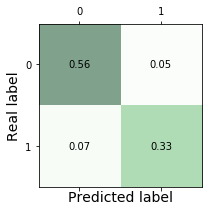

In [32]:
plot_confusion_matrix(y_train, y_train_pred)

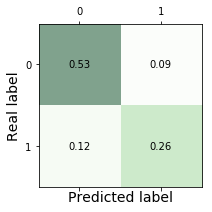

In [33]:
plot_confusion_matrix(y_test, y_test_pred)

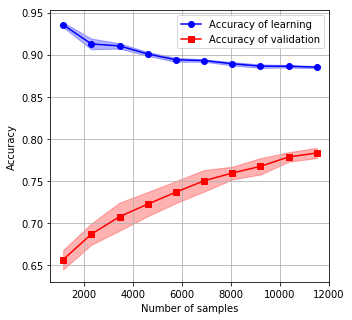

In [34]:
plot_learning_curve(estimator=lem_lr_model, X=X_train_lem_preprocessed, y=y_train)

### RandomForestClassifier

In [35]:
from sklearn.ensemble import RandomForestClassifier

In [63]:
def get_sorted_features(pipe, selector_scores):
    sorted_scores = np.sort(selector_scores)[::-1]
    inds = np.argsort(selector_scores)[::-1]
    word_list = list(pipe.named_steps['features'].transformer_list[1][1].\
                     named_steps['vectorizer'].get_feature_names())
    tag_list = ['NOUN_r', 'VERB_r', 'ADJ_r', 'ADV_r', 'PRON_r', 'DET_r',
                'ADP_r', 'NUM_r', 'CONJ_r', 'PRT_r', '._r', 'X_r']
    freq_name_list = ['repeatingletters_r', 'uppercase_r', 'firstcapital_r'] + tag_list
    sorted_features = np.array(word_list + freq_name_list)[inds]
    return sorted_features

def print_kbest(pipe, selector_scores, k):
    sorted_scores = np.sort(selector_scores)[::-1]
    sorted_features = get_sorted_features(pipe, selector_scores)
    for i in range(k):
        print('Feature: {0:25s} Score: {1:8.3f}'.format(sorted_features[i], sorted_scores[i]))

In [42]:
stem_rfc_model = RandomForestClassifier(n_estimators=100, max_depth=15, max_features=1000)

stem_rfc_model.fit(X_train_stem_preprocessed, y_train);

y_train_pred = stem_rfc_model.predict(X_train_stem_preprocessed)
y_test_pred = stem_rfc_model.predict(X_test_stem_preprocessed)

print('Tarining dataset: accuracy = %.3f' % accuracy_score(y_pred=y_train_pred, y_true=y_train))
print('Test dataset: accuracy = %.3f' % accuracy_score(y_pred=y_test_pred, y_true=y_test))

Tarining dataset: accuracy = 0.859
Test dataset: accuracy = 0.781


In [43]:
y_train_proba = stem_rfc_model.predict_proba(X_train_stem_preprocessed)[:, 1]
y_test_proba = stem_rfc_model.predict_proba(X_test_stem_preprocessed)[:, 1]
print('Tarining dataset: roc_auc = %.3f' % roc_auc_score(y_score=y_train_proba, y_true=y_train))
print('Test dataset: roc_auc = %.3f' % roc_auc_score(y_score=y_test_proba, y_true=y_test))

Tarining dataset: roc_auc = 0.958
Test dataset: roc_auc = 0.877


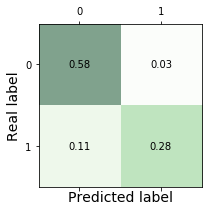

In [44]:
plot_confusion_matrix(y_train, y_train_pred)

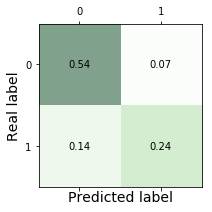

In [45]:
plot_confusion_matrix(y_test, y_test_pred)

In [46]:
print_kbest(stem_pipe, stem_rfc_model.feature_importances_, 10)

Feature: fun                       Score:    0.090
Feature: oracl                     Score:    0.044
Feature: blah                      Score:    0.035
Feature: abbey                     Score:    0.034
Feature: athlet                    Score:    0.034
Feature: abil                      Score:    0.034
Feature: academi                   Score:    0.028
Feature: aardvark                  Score:    0.027
Feature: absit                     Score:    0.026
Feature: german                    Score:    0.024


In [47]:
lem_rfc_model = RandomForestClassifier(n_estimators=100, max_depth=15, max_features=1000)
lem_rfc_model.fit(X_train_stem_preprocessed, y_train);

y_train_pred = lem_rfc_model.predict(X_train_stem_preprocessed)
y_test_pred = lem_rfc_model.predict(X_test_stem_preprocessed)

print('Tarining dataset: accuracy = %.3f' % accuracy_score(y_pred=y_train_pred, y_true=y_train))
print('Test dataset: accuracy = %.3f' % accuracy_score(y_pred=y_test_pred, y_true=y_test))

Tarining dataset: accuracy = 0.857
Test dataset: accuracy = 0.780


In [48]:
y_train_proba = lem_rfc_model.predict_proba(X_train_stem_preprocessed)[:, 1]
y_test_proba = lem_rfc_model.predict_proba(X_test_stem_preprocessed)[:, 1]
print('Tarining dataset: roc_auc = %.3f' % roc_auc_score(y_score=y_train_proba, y_true=y_train))
print('Test dataset: roc_auc = %.3f' % roc_auc_score(y_score=y_test_proba, y_true=y_test))

Tarining dataset: roc_auc = 0.959
Test dataset: roc_auc = 0.882


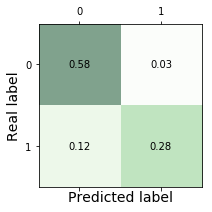

In [49]:
plot_confusion_matrix(y_train, y_train_pred)

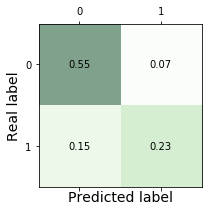

In [50]:
plot_confusion_matrix(y_test, y_test_pred)

In [51]:
print_kbest(lem_pipe, lem_rfc_model.feature_importances_, 10)

Feature: foggy                     Score:    0.090
Feature: neon                      Score:    0.042
Feature: ass                       Score:    0.035
Feature: ability                   Score:    0.034
Feature: birthday                  Score:    0.034
Feature: abbey                     Score:    0.030
Feature: academy                   Score:    0.028
Feature: aardvark                  Score:    0.026
Feature: absitence                 Score:    0.026
Feature: fresh                     Score:    0.026


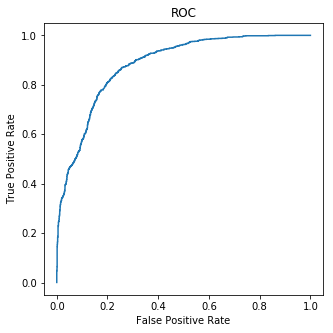

In [52]:
plot_roc_curve(y_labels=y_test, y_proba=y_test_proba)

In [53]:
fprs, tprs, thresholds = roc_curve(y_true=y_test, y_score=y_test_proba)
ind = np.argmax(tprs >= 0.75)

print('FPR: %.3f' % fprs[ind])
print('TPR: %.3f' % tprs[ind])
threshold = thresholds[ind]
print('Threshold: %.3f' % threshold)

FPR: 0.158
TPR: 0.751
Threshold: 0.444


In [54]:
y_test_pred_new_threshold = np.where(y_test_proba >= threshold, 1, 0)
print('Test dataset: accuracy = %.3f' % accuracy_score(y_pred=y_test_pred_new_threshold, y_true=y_test))

Test dataset: accuracy = 0.807


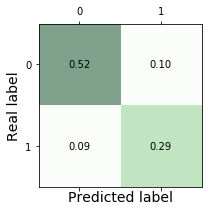

In [55]:
plot_confusion_matrix(y_test, y_test_pred_new_threshold)

## Feature selection

### ANOVA

In [56]:
from sklearn.feature_selection import f_classif, SelectFpr

In [57]:
fpr_stem_selector = SelectFpr(score_func=f_classif, alpha=0.01)
fpr_stem_dtm = fpr_stem_selector.fit_transform(X_train_stem_preprocessed, y_train)
fpr_stem_dtm.shape

(12776, 280)

In [58]:
fpr_lem_selector = SelectFpr(score_func=f_classif, alpha=0.01)
fpr_lem_dtm = fpr_lem_selector.fit_transform(X_train_lem_preprocessed, y_train)
fpr_lem_dtm.shape

(12776, 281)

In [59]:
print_kbest(stem_pipe, fpr_stem_selector.scores_, 10)

Feature: fun                       Score:  564.091
Feature: oracl                     Score:  211.210
Feature: athlet                    Score:  200.388
Feature: blah                      Score:  186.842
Feature: german                    Score:  112.768
Feature: aardvark                  Score:   91.561
Feature: eww                       Score:   91.526
Feature: endless                   Score:   86.940
Feature: whirlpool                 Score:   80.985
Feature: oprah                     Score:   77.777


In [60]:
print_kbest(lem_pipe, fpr_lem_selector.scores_, 10)

Feature: fukk                      Score:  416.894
Feature: ops                       Score:  211.210
Feature: blackstone                Score:  186.877
Feature: assmartini                Score:  151.504
Feature: funny                     Score:  141.047
Feature: generator                 Score:  114.922
Feature: aardvark                  Score:   91.561
Feature: ew                        Score:   91.526
Feature: enclose                   Score:   82.782
Feature: oprah                     Score:   77.777


In [64]:
sorted_features = get_sorted_features(stem_pipe, fpr_stem_selector.scores_)
print(sorted_features[:fpr_stem_dtm.shape[1]])

['fun' 'oracl' 'athlet' 'blah' 'german' 'aardvark' 'eww' 'endless'
 'whirlpool' 'oprah' 'energi' 'shortar' 'opposit' 'domin' "they'll" 'feet'
 'aay' "he'd" 'sumth' 'aah' 'ust' 'love' 'cutest' 'wiff' 'shuck' 'marker'
 'hamster' 'nowaday' 'wrong' 'yua' 'imposs' 'hint' 'collar' 'homophob'
 'abt' 'idiot' 'favrd' 'radar' 'shia' 'url' 'noarmsjam' 'umm' 'yew'
 'duncan' 'wth' 'digit' 'fairi' 'rais' 'ili' 'dare' 'abl' 'sucki' 'heavi'
 'hear' 'lulz' 'haiku' 'smoke' 'marathon' 'queer' 'ohkay' 'threaten'
 'abort' 'pa' 'wit' 'absurd' 'known' 'echelon' 'goos' 'megavideo' 'darlin'
 'gotten' 'quest' 'ho' 'yesterday' 'silli' 'phenomenon' 'kasumi' 'seattl'
 'bush' 'abus' 'anna' 'oppos' 'azn' 'cigar' 'soundtrack' 'familiar'
 'shrink' 'rewatch' 'jamaican' 'price' 'draw' 'canadian' 'selfless' 'mari'
 'newsroom' 'sapien' 'bm' 'bike' 'set' 'limit' 'unfollow' 'admir' 'marri'
 'realiz' 'youngest' 'bf' 'mic' 'five' 'youu' 'zero' 'fork' 'temperatur'
 'regularli' 'het' 'download' 'md' 'coweta' 'fund' 'suggest' 'c

In [65]:
sorted_features = get_sorted_features(lem_pipe, fpr_lem_selector.scores_)
print(sorted_features[:fpr_lem_dtm.shape[1]])

['fukk' 'ops' 'blackstone' 'assmartini' 'funny' 'generator' 'aardvark'
 'ew' 'enclose' 'oprah' 'end' 'shore' 'oppose' 'whilst' 'thermometer'
 'felching' 'aaye' 'dominate' 'hd' 'aah' 'summer' 'hold' 'uss' 'love'
 'cut' 'wife' 'shud' 'marker' 'hand' 'colfax' 'wtf' 'november' 'impress'
 'yuck' 'honesty' "sun's" 'fb' 'uranus' 'abt' 'identical' 'rad' 'shia'
 'yet' 'dump' 'umm' 'digestive' 'fairy' 'wut' 'whip' 'rainbow' 'sucker'
 'nk' 'il' 'dare' 'able' 'meh' 'likee' 'healing' 'mar' 'hahha' 'ohio' 'pa'
 'threaten' 'sms' 'abortion' 'queer' 'witch' 'absurd' 'knw' 'gordon'
 'darlings' 'rhetoric' 'gotta' 'quest' 'hm' 'heatsink' 'sike'
 'luckystartups' 'kasumi' 'bury' 'abuse' 'ankle' 'ay' 'then' 'york' 'hbu'
 'cigar' 'opinion' 'economy' 'soundtrack' 'fam' 'shuck' 'schnauzer' 'jake'
 'certain' 'pride' 'drama' 'canadians' 'mark' 'blurry' 'biker' 'gimme'
 'unfair' 'address' 'fun' 'marriage' 'realize' 'youre' 'beyond' 'newly'
 'michael' 'zero' 'temp' 'formspring' 'regret' 'hermy' 'download' 'kids'
 '

In [66]:
fpr_stem_pipe = Pipeline([
    ('selector', SelectFpr(score_func=f_classif, alpha=0.01)),
    ('clf', LogisticRegression(penalty='l2', C=1.0))
    ])

In [67]:
fpr_stem_pipe.fit(X_train_stem_preprocessed, y_train);

y_train_pred = fpr_stem_pipe.predict(X_train_stem_preprocessed)
y_test_pred = fpr_stem_pipe.predict(X_test_stem_preprocessed)

print('Tarining dataset: accuracy = %.3f' % accuracy_score(y_pred=y_train_pred, y_true=y_train))
print('Test dataset: accuracy = %.3f' % accuracy_score(y_pred=y_test_pred, y_true=y_test))

Tarining dataset: accuracy = 0.734
Test dataset: accuracy = 0.718


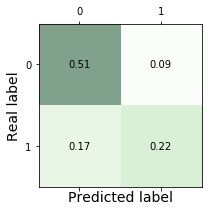

In [68]:
plot_confusion_matrix(y_train, y_train_pred)

In [69]:
fpr_stem_pipe = Pipeline([
    ('selector', SelectFpr(score_func=f_classif, alpha=0.01)),
    ('clf', LogisticRegression(penalty='l2', C=1.0, class_weight={0: 1, 1: 1.25}))
    ])

fpr_stem_pipe.fit(X_train_stem_preprocessed, y_train);

y_train_pred = fpr_stem_pipe.predict(X_train_stem_preprocessed)
y_test_pred = fpr_stem_pipe.predict(X_test_stem_preprocessed)

print('Tarining dataset: accuracy = %.3f' % accuracy_score(y_pred=y_train_pred, y_true=y_train))
print('Test dataset: accuracy = %.3f' % accuracy_score(y_pred=y_test_pred, y_true=y_test))

Tarining dataset: accuracy = 0.737
Test dataset: accuracy = 0.716


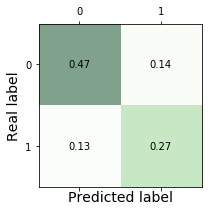

In [70]:
plot_confusion_matrix(y_train, y_train_pred)

### Variance

In [71]:
from sklearn.feature_selection import VarianceThreshold

In [72]:
vr_stem_selector = VarianceThreshold(threshold=10e-4)
vr_stem_dtm = vr_stem_selector.fit_transform(X_train_stem_preprocessed, y_train)
vr_stem_dtm.shape

(12776, 795)

In [73]:
vr_lem_selector = VarianceThreshold(threshold=10e-4)
vr_lem_dtm = vr_lem_selector.fit_transform(X_train_lem_preprocessed, y_train)
vr_lem_dtm.shape

(12776, 754)

In [74]:
print_kbest(stem_pipe, vr_stem_selector.variances_, 10)

Feature: abbey                     Score:    0.033
Feature: aay                       Score:    0.024
Feature: whirlpool                 Score:    0.019
Feature: sumth                     Score:    0.019
Feature: absit                     Score:    0.018
Feature: aardvark                  Score:    0.017
Feature: academi                   Score:    0.017
Feature: kasumi                    Score:    0.016
Feature: absorb                    Score:    0.015
Feature: they'll                   Score:    0.015


In [75]:
print_kbest(lem_pipe, vr_lem_selector.variances_, 10)

Feature: abbey                     Score:    0.033
Feature: aaye                      Score:    0.024
Feature: thermometer               Score:    0.023
Feature: sun's                     Score:    0.018
Feature: absitence                 Score:    0.018
Feature: aardvark                  Score:    0.017
Feature: academy                   Score:    0.017
Feature: whilst                    Score:    0.017
Feature: kasumi                    Score:    0.016
Feature: absorb                    Score:    0.015


In [67]:
sorted_features = get_sorted_features(stem_pipe, vr_stem_selector.variances_)
print(sorted_features[:vr_stem_dtm.shape[1]][:200])

['abandon' 'abil' 'aay' 'aardvark' 'absit' 'abus' 'absorb' 'dunkin' 'abt'
 'dom' 'jacob' 'dose' 'abund' 'athlet' 'adob' 'blame' 'wonder' 'dine' 'he'
 'whine' 'loop' 'fun' 'gotta' 'kids' 'flashlight' 'mankind' 'arsclan'
 'babay' 'induc' 'ideal' 'toyboy' 'amberto' 'shud' 'abort' 'faith'
 'niggaitu' 'ceo' 'hey' 'engag' 'wouldnt' 'amaz' 'energi' 'souljaboy'
 'mario' 'awz' 'thre' 'abl' 'krista' 'analyz' 'oppos' 'naked' 'musician'
 'lotto' 'sent' 'robot' 'umbrella' 'nova' 'ani' 'aah' 'nerv' 'util' 'mapl'
 'heal' 'ive' 'air' 'mind' 'crisi' 'southern' 'ohio' 'shortar' 'absolut'
 'attent' 'stoopid' 'lit' 'threat' 'airplan' 'theori' 'valu' 'nah' 'yhu'
 'dare' 'down' 'exact' 'hahlo' 'project' 'cutest' 'schedul' 'bull' 'evolv'
 'commut' 'coweta' 'eminem' 'aint' 'uhh' 'girl' 'recov' 'honestli' 'soup'
 'els' 'terrifi' 'capitalist' 'holla' 'romo' 'pastor' 'kingston' 'persist'
 'eagl' 'lawn' 'workhors' 'baltimor' 'stripe' 'holli' 'fla' 'belief'
 'hotdog' 'throughout' 'opposit' 'tryin' 'weekend' 'altho

In [76]:
sorted_features = get_sorted_features(lem_pipe, vr_lem_selector.variances_)
print(sorted_features[:vr_lem_dtm.shape[1]][:200])

['abbey' 'aaye' 'thermometer' "sun's" 'absitence' 'aardvark' 'academy'
 'whilst' 'kasumi' 'absorb' 'abt' 'jacket' 'industry' 'thts' 'hosting'
 'uranus' 'threaten' 'ability' 'dominate' 'attract' 'oppose' 'doubt'
 'gotta' 'gimme' 'identity' 'manhattan' 'gov' 'healing' 'kids' 'whip'
 "won't" 'fix' 'hd' 'ive' 'marker' 'longer' 'watcher' 'flare' 'ankle'
 'apparently' 'correct' 'whatever' 'ambien' 'arrive' 'ba' 'abortion'
 'admire' 'identical' 'plug' 'september' 'censorship' 'reckless' 'niggaz'
 'amazingly' 'ohio' 'hermy' 'kn' 'endure' 'goof' 'abuse' 'thread' 'soul'
 'toy' 'krystle' 'end' 'an' 'able' 'wrap' 'fairy' 'hold' 'receive'
 'decide' 'funny' 'throughout' 'assmartini' 'animate' 'robin' 'nessarenee'
 'sp' 'mar' 'lottery' 'wtf' 'aah' 'cripple' 'november' 'yuck' 'baltimore'
 'laying' 'uss' 'summer' 'ax' 'story' 'best' 'absolutely' 'terror'
 'umbracians' 'lipstick' 'community' "they'd" 'fukk' 'yesterday' 'mind'
 'fraking' 'opinion' 'meh' 'valid' 'darlings' 'ew' 'schnauzer' 'shore'
 'progr

In [89]:
vr_stem_pipe = Pipeline([
    ('selector', VarianceThreshold(threshold=10e-4)),
    ('clf', LogisticRegression(penalty='l2', C=1.0, class_weight={0: 1, 1: 1.15}))
    ])

vr_stem_pipe.fit(X_train_stem_preprocessed, y_train);

y_train_pred = vr_stem_pipe.predict(X_train_stem_preprocessed)
y_test_pred = vr_stem_pipe.predict(X_test_stem_preprocessed)

print('Tarining dataset: accuracy = %.3f' % accuracy_score(y_pred=y_train_pred, y_true=y_train))
print('Test dataset: accuracy = %.3f' % accuracy_score(y_pred=y_test_pred, y_true=y_test))

Tarining dataset: accuracy = 0.755
Test dataset: accuracy = 0.723


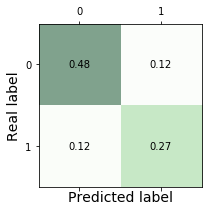

In [90]:
plot_confusion_matrix(y_train, y_train_pred)

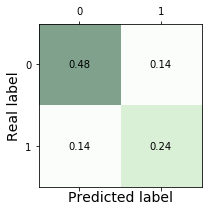

In [91]:
plot_confusion_matrix(y_test, y_test_pred)

## Hyperparameter Tuning

In [92]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import Normalizer

from scipy.stats.distributions import uniform, randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from scipy.spatial.distance import cosine
from pprint import pprint
from sklearn.base import clone

### Number of features

#### Feature selection - CountVectorizer

In [93]:
def count_features(pipe_trans, param_range, param_name, process):
    pipe = clone(pipe_trans)
    no_features = []
    for param in param_range:
        pipe.set_params(**{'preprocessor__process': process, param_name: param})
        dtm = pipe.fit_transform(X_train)
        no_features.append(dtm.shape[1])
    return no_features

def plot_no_features(pipe_trans, param_range, param_name, process):    
    no_features = count_features(pipe_trans, param_range, param_name, process)
    
    fig, ax = plt.subplots(figsize=(5, 5))    
    ax.plot(param_range, no_features, '--o')
    ax.set_xlabel(param_name)
    ax.set_ylabel('Number of features')
    ax.set_title('Process = ' + process)
    ax.grid()
    plt.show()    

In [94]:
tf_pipe = Pipeline([('preprocessor', TextPreprocessor()),
                    ('vectorizer', CountVectorizer(token_pattern=token_pattern))
                   ])

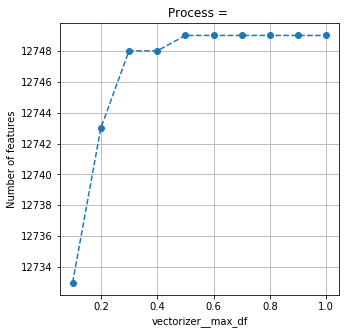

In [95]:
max_df_range = np.arange(0.1, 1.1, 0.1)
process = ''
param_name = 'vectorizer__max_df'
plot_no_features(tf_pipe, max_df_range, param_name, process)

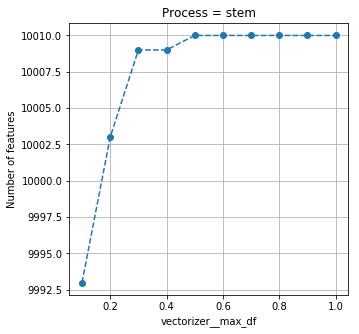

In [96]:
max_df_range = np.arange(0.1, 1.1, 0.1)
process = 'stem'
param_name = 'vectorizer__max_df'
plot_no_features(tf_pipe, max_df_range, param_name, process)

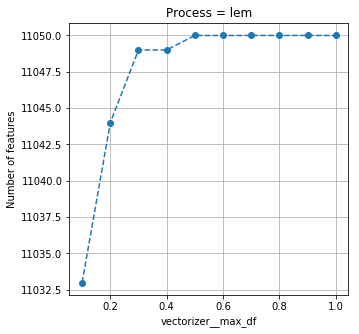

In [97]:
max_df_range = np.arange(0.1, 1.1, 0.1)
process = 'lem'
param_name = 'vectorizer__max_df'
plot_no_features(tf_pipe, max_df_range, param_name, process)

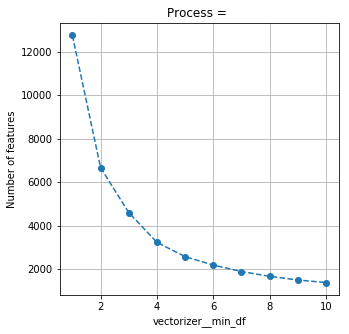

In [98]:
min_df_range = np.arange(1, 11, 1)
process = ''
param_name = 'vectorizer__min_df'
plot_no_features(tf_pipe, min_df_range, param_name, process)

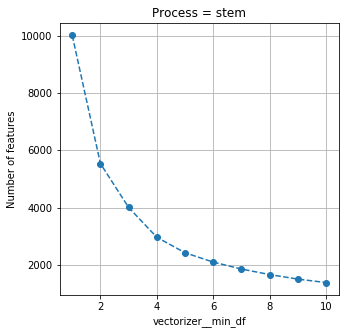

In [99]:
min_df_range = np.arange(1, 11, 1)
process = 'stem'
param_name = 'vectorizer__min_df'
plot_no_features(tf_pipe, min_df_range, param_name, process)

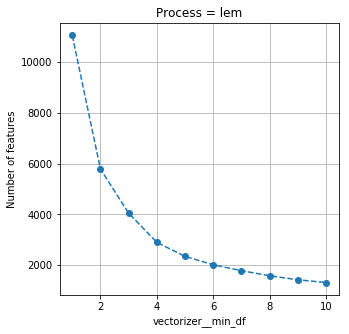

In [100]:
min_df_range = np.arange(1, 11, 1)
process = 'lem'
param_name = 'vectorizer__min_df'
plot_no_features(tf_pipe, min_df_range, param_name, process)

In [101]:
ngram_range = [(1, 1), (1, 2), (2, 2), (1, 3)]
process = ''
param_name = 'vectorizer__ngram_range'
count_features(tf_pipe, ngram_range, param_name, process)

[12749, 81774, 69025, 187067]

In [102]:
ngram_range = [(1, 1), (1, 2), (2, 2), (1, 3)]
process = 'stem'
param_name = 'vectorizer__ngram_range'
count_features(tf_pipe, ngram_range, param_name, process)

[10010, 75284, 65274, 179641]

In [103]:
ngram_range = [(1, 1), (1, 2), (2, 2), (1, 3)]
process = 'lem'
param_name = 'vectorizer__ngram_range'
count_features(tf_pipe, ngram_range, param_name, process)

[11050, 76978, 65928, 181506]

#### Feature extraction - SVD

In [104]:
lsi_pipe= Pipeline([('preprocessor', TextPreprocessor()),
                    ('vectorizer', TfidfVectorizer(token_pattern=token_pattern, norm='l2')),
                    ('svd', TruncatedSVD())
                    ])

In [105]:
component_range = np.arange(100, 2000, 100)
explained_variance = []
for n in component_range:
    lsi_pipe.set_params(**{'svd__n_components': n})
    dtm = lsi_pipe.fit_transform(X_train)
    variance = lsi_pipe.named_steps['svd'].explained_variance_ratio_.sum()
    explained_variance.append(variance)

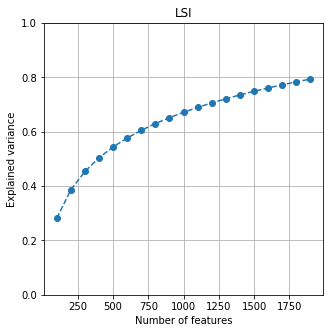

In [106]:
fig, ax = plt.subplots(figsize=(5, 5))    
ax.plot(component_range, explained_variance, '--o')
ax.set_xlabel('Number of features')
ax.set_ylabel('Explained variance')
ax.set_title('LSI')
ax.set_ylim(0, 1)
ax.grid()
plt.show()

In [107]:
lsi_pipe.set_params(**{'svd__n_components': 2})
svd_dtm = lsi_pipe.fit_transform(X_train)
print('Explained variance = %.3f' % lsi_pipe.named_steps['svd'].explained_variance_ratio_.sum())

Explained variance = 0.017


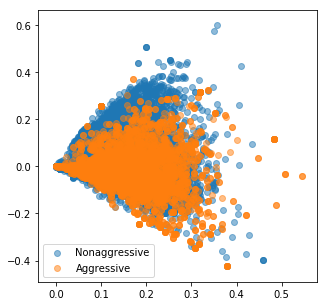

In [108]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(svd_dtm[y_train == 0, 0], svd_dtm[y_train == 0, 1], label='Nonaggressive', alpha=0.5)
ax.scatter(svd_dtm[y_train == 1, 0], svd_dtm[y_train == 1, 1], label='Aggressive', alpha=0.5)
plt.legend()
plt.show()

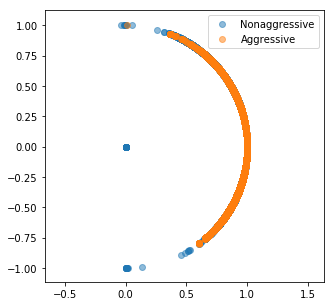

In [109]:
svd_dtm_normalized = Normalizer().fit_transform(svd_dtm)

fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(svd_dtm_normalized[y_train == 0, 0], svd_dtm_normalized[y_train == 0, 1], 
           label='Nonaggressive', alpha=0.5)
ax.scatter(svd_dtm_normalized[y_train == 1, 0], svd_dtm_normalized[y_train == 1, 1], 
           label='Aggressive', alpha=0.5)
plt.axis('equal')
plt.legend()
plt.show()

In [110]:
lsi_pipe = Pipeline([('preprocessor', TextPreprocessor()),
                     ('vectorizer', TfidfVectorizer(token_pattern=token_pattern, norm='l2',
                                                    ngram_range=(1, 2), min_df=2)),
                     ('svd', TruncatedSVD())
                    ])

In [111]:
component_range = np.arange(100, 2000, 100)
explained_variance = []
for n in component_range:
    lsi_pipe.set_params(**{'svd__n_components': n})
    dtm = lsi_pipe.fit_transform(X_train)
    variance = lsi_pipe.named_steps['svd'].explained_variance_ratio_.sum()
    explained_variance.append(variance)

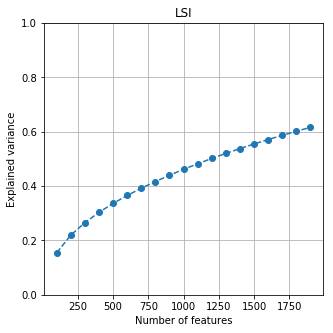

In [112]:
fig, ax = plt.subplots(figsize=(5, 5))    
ax.plot(component_range, explained_variance, '--o')
ax.set_xlabel('Number of features')
ax.set_ylabel('Explained variance')
ax.set_title('LSI')
ax.set_ylim(0, 1)
ax.grid()
plt.show()

### Transformers

#### CountVectorizer: Term Frequency

In [113]:
tf_pipe = Pipeline([
    ('features', FeatureUnion([
            ('freq_feats', FrequencyExtractor()),    
            ('text_feats', Pipeline([('preprocessor', TextPreprocessor(stopwords=IRRELEVANT_STOPWORDS, 
                                                                       process='stem')),
                                     ('vectorizer', CountVectorizer(token_pattern=token_pattern, min_df=2,
                                                                    ngram_range=(1, 2)))
                                    ]))
            ])),
    ('scaler', MaxAbsScaler())
    ])

preprocessor_path = 'transformer__features__text_feats__preprocessor'
vectorizer_path = 'transformer__features__text_feats__vectorizer'
tf_param_dist = {preprocessor_path + '__stopwords': [IRRELEVANT_STOPWORDS, STOPWORDS, []],
                 preprocessor_path + '__process': ['lem', 'stem', ''],
                 vectorizer_path + '__ngram_range': [(1, 1), (1, 2), (2, 2)],
                 vectorizer_path + '__min_df': randint(1, 6)
                 }

In [114]:
tf_dtm_train = tf_pipe.fit_transform(X_train)
tf_dtm_test = tf_pipe.transform(X_test)

#### TfidfVectorizer: Term Frequency - Inverse Document Frequency

In [115]:
tfidf_pipe = Pipeline([
    ('features', FeatureUnion([
            ('freq_feats', FrequencyExtractor()),    
            ('text_feats', Pipeline([('preprocessor', TextPreprocessor(stopwords=IRRELEVANT_STOPWORDS, 
                                                                       process='stem')),
                                     ('vectorizer', TfidfVectorizer(token_pattern=token_pattern, min_df=2,
                                                                    ngram_range=(1, 2), norm='l2'))
                                    ]))
            ]))
    ])

tfidf_param_dist = {preprocessor_path + '__stopwords': [IRRELEVANT_STOPWORDS, STOPWORDS, []],
                    preprocessor_path + '__process': ['lem', 'stem', ''],
                    vectorizer_path + '__ngram_range': [(1, 1), (1, 2), (2, 2)],
                    vectorizer_path + '__min_df': randint(1, 6)
                    }

In [116]:
tfidf_dtm_train = tfidf_pipe.fit_transform(X_train)
tfidf_dtm_test = tfidf_pipe.transform(X_test)

#### SVD: Singular Value Decomposition (Latent Semantic Indexing)

In [117]:
lsi_pipe = Pipeline([
    ('features', FeatureUnion([
            ('freq_feats', FrequencyExtractor()),    
            ('text_feats', Pipeline([('preprocessor', TextPreprocessor(stopwords=IRRELEVANT_STOPWORDS, 
                                                                       process='stem')),
                                     ('vectorizer', TfidfVectorizer(token_pattern=token_pattern, min_df=2,
                                                                    ngram_range=(1, 2), norm='l2')),
                                     ('svd', TruncatedSVD(n_components=750)),
                                     ('normalizer', Normalizer())
                                    ]))
            ]))
    ])

svd_path = 'transformer__features__text_feats__svd'
lsi_param_dist = {preprocessor_path + '__stopwords': [IRRELEVANT_STOPWORDS, STOPWORDS, []],
                  preprocessor_path + '__process': ['lem', 'stem', ''],
                  vectorizer_path + '__ngram_range': [(1, 1), (1, 2), (2, 2)],
                  vectorizer_path + '__min_df': randint(1, 6),
                  svd_path + '__n_components': randint(100, 2000)
                  }

In [118]:
lsi_dtm_train = lsi_pipe.fit_transform(X_train)
lsi_dtm_test = lsi_pipe.transform(X_test)

In [119]:
lsi_pipe.named_steps['features'].transformer_list[1][1].named_steps['svd'].explained_variance_ratio_.sum()

0.42079764732096736

#### LatentDirichletAllocation

In [124]:
lda_pipe = Pipeline([
    ('features', FeatureUnion([
            ('freq_feats', FrequencyExtractor()),    
            ('text_feats', Pipeline([('preprocessor', TextPreprocessor(stopwords=IRRELEVANT_STOPWORDS, 
                                                                       process='stem')),
                                     ('vectorizer', TfidfVectorizer(token_pattern=token_pattern, min_df=2,
                                                                    ngram_range=(1, 2), norm='l2')),
                                     ('lda', LatentDirichletAllocation(n_components=25, learning_method='online', 
                                                                       doc_topic_prior=0.1,
                                                                       topic_word_prior=0.1))
                                    ]))
            ]))
    ])

lda_path = 'transformer__features__text_feats__lda'
lda_param_dist = {preprocessor_path + '__stopwords': [IRRELEVANT_STOPWORDS, STOPWORDS, []],
                  preprocessor_path + '__process': ['lem', 'stem', ''],
                  vectorizer_path + '__ngram_range': [(1, 1), (1, 2), (2, 2)],
                  vectorizer_path + '__min_df': randint(1, 6),
                  lda_path + '__n_components': randint(10, 50),
                  lda_path + '__doc_topic_prior': uniform(0.01, 3 - 0.01),
                  lda_path + '__topic_word_prior': uniform(0.01, 3 - 0.01)
                  }

In [125]:
lda_dtm_train = lda_pipe.fit_transform(X_train)
lda_dtm_test = lda_pipe.transform(X_test)

In [126]:
X_train_dict = {'tf': tf_dtm_train,
                'tfidf': tfidf_dtm_train,
                'lsi': lsi_dtm_train,
                'lda': lda_dtm_train,
                'original': X_train
                }

X_test_dict = {'tf': tf_dtm_test,
               'tfidf': tfidf_dtm_test,
               'lsi': lsi_dtm_test,
               'lda': lda_dtm_test,
               'original': X_test
               }

In [161]:
transformers = [('tf', tf_pipe),
                ('tfidf', tfidf_pipe),
#                 ('lsi', lsi_pipe),
#                 ('lda', lda_pipe)                
               ]

transformers_param_dist = {'tf': tf_param_dist,
                           'tfidf': tfidf_param_dist,
                           'lsi': lsi_param_dist,
                           'lda': lda_param_dist
                          }

### Estimators

In [128]:
estimators = {'lr': LogisticRegression(),
              'lin_svm': SVC(kernel='linear', probability=True),
              'rbf_svm': SVC(kernel='rbf', probability=True),
              'dt': DecisionTreeClassifier(),
              'knn': KNeighborsClassifier(),
              'nb': GaussianNB(),
              'lda': LinearDiscriminantAnalysis(),
              'qda': QuadraticDiscriminantAnalysis(),
             }

estimators_param_dist = {'lr': {'clf__penalty': ['l1', 'l2'],
                                'clf__C': uniform(0., 4.)},
                         'lin_svm': {'clf__C': uniform(0., 4.)},
                         'rbf_svm': {'clf__C': uniform(0., 4.),
                                     'clf__gamma': uniform(0.1, 3 - 0.1)},
                         'dt': {'clf__max_depth': randint(5, 15),
                                'clf__min_samples_leaf': randint(2, 40)},
                         'knn': {'clf__n_neighbors': randint(4, 15),
                                 'clf__metric': ['minkowski', cosine]},
                         'nb': {}, 
                         'lda': {},
                         'qda': {},
                        }

### Classification

In [129]:
def search_best_clfs(clf_name, X_train_dict, X_test_dict, transformation=False, n_iter=3):
    best_clfs = {}
    scores = pd.DataFrame(columns=[clf_name + '_train', clf_name + '_test'])

    for trans_name, trans_pipe in transformers:
        print(trans_name)
        if transformation:
            pipe = Pipeline([('transformer', clone(trans_pipe)),
                             ('clf', clone(estimators[clf_name]))])

            param_dist = transformers_param_dist[trans_name].copy()
            param_dist.update(estimators_param_dist[clf_name].items())
            
            X_train = X_train_dict['original']
            X_test = X_test_dict['original']
        else:
            pipe = Pipeline([('clf', clone(estimators[clf_name]))])
            param_dist = estimators_param_dist[clf_name]
            
            X_train = X_train_dict[trans_name]
            X_test = X_test_dict[trans_name]

        rs = RandomizedSearchCV(estimator=pipe, param_distributions=param_dist, 
                                n_iter=n_iter, n_jobs=-1, refit=True,
                                scoring='accuracy',
                                cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=10))

        rs.fit(X_train, y_train)

        best_clfs.update({trans_name: rs.best_estimator_})

        train_score = rs.score(X_train, y_train)
        test_score = rs.score(X_test, y_test)
        scores.loc[trans_name] = [train_score, test_score]
        
    return best_clfs, scores

In [25]:
import pickle
import os

In [23]:
def save_model(model, file_name):
    models_path = './Models'
    if not os.path.exists(models_path):
        os.makedirs(models_path)
    
    with open(os.path.join(models_path, file_name), 'wb') as file:
        pickle.dump(model, file, protocol=4)

In [132]:
def save_kbest(kbest_array, file_name):
    models_path = './kBest'
    if not os.path.exists(models_path):
        os.makedirs(models_path)

    np.savetxt(os.path.join(models_path, file_name), kbest_array, fmt='%s')

#### Logistic Regression

In [133]:
clf_name = 'lr'
best_lrs, lr_scores = search_best_clfs(clf_name, X_train_dict, X_test_dict, n_iter=3)

tf
tfidf
lsi
lda


In [134]:
lr_scores

,lr_train,lr_test
tf,0.989042,0.883845
tfidf,0.962116,0.845022
lsi,0.778569,0.738885
lda,0.764950,0.708203


In [135]:
for name, model in best_lrs.items():
    file_name = name + '_logisticregression.p'
    save_model(model, file_name)

In [136]:
pprint(best_lrs['tf'].named_steps['clf'].get_params())

{'C': 3.519444884629227,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'ovr',
 'n_jobs': 1,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


In [137]:
pprint(best_lrs['tfidf'].named_steps['clf'].get_params())

{'C': 3.3744367769734565,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'ovr',
 'n_jobs': 1,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


In [138]:
pprint(best_lrs['lsi'].named_steps['clf'].get_params())

{'C': 3.713284351766094,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'ovr',
 'n_jobs': 1,
 'penalty': 'l1',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


In [139]:
pprint(best_lrs['lda'].named_steps['clf'].get_params())

{'C': 2.1371252447786278,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'ovr',
 'n_jobs': 1,
 'penalty': 'l1',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


We can look at the learning and validation curve to check overfitting/underfitting

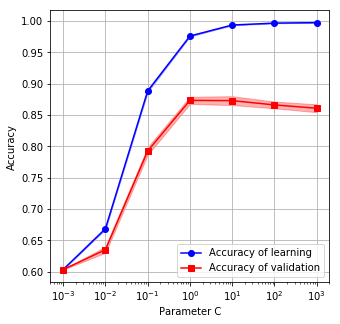

In [140]:
trans_name = 'tf'
plot_validation_curve(estimator=clone(best_lrs[trans_name]), X=X_train_dict[trans_name], y=y_train, 
                      param_name='clf__C', param_range=np.logspace(-3, 3, 7), x_scale='log')

In [147]:
trans_name = 'tf'
lr_pipe = clone(best_lrs[trans_name])
lr_pipe.set_params(**{'clf__C': 1.})

lr_pipe.fit(X_train_dict[trans_name], y_train);

y_train_pred = lr_pipe.predict(X_train_dict[trans_name])
y_test_pred = lr_pipe.predict(X_test_dict[trans_name])
print('Tarining dataset: accuracy = %.3f' % accuracy_score(y_pred=y_train_pred, y_true=y_train))
print('Test dataset: accuracy = %.3f' % accuracy_score(y_pred=y_test_pred, y_true=y_test))

Tarining dataset: accuracy = 0.975
Test dataset: accuracy = 0.873


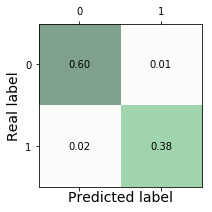

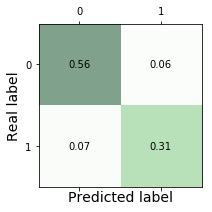

In [148]:
plot_confusion_matrix(y_train, y_train_pred)
plot_confusion_matrix(y_test, y_test_pred)

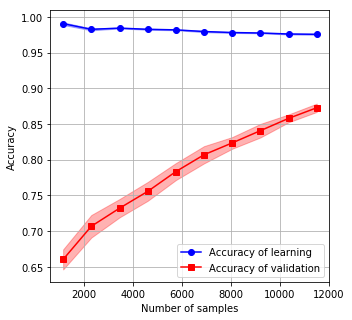

In [149]:
plot_learning_curve(estimator=clone(lr_pipe), X=X_train_dict[trans_name], y=y_train)

In [150]:
from sklearn.model_selection import cross_val_score
import scipy

In [151]:
# X_extended = scipy.sparse.vstack([X_train_dict[trans_name], X_test_dict[trans_name]])
# X_extended.shape

In [152]:
X_extended = np.r_[X_train, X_test]
y_extended = np.r_[y_train, y_test]
print(X_extended.shape, y_extended.shape)

(15970,) (15970,)


In [153]:
lr_pipe_extended = Pipeline([('transformers', clone(tf_pipe)),
                             ('clf', clone(lr_pipe.named_steps['clf']))])

extended_scores = cross_val_score(lr_pipe_extended, X_extended, y_extended, scoring='accuracy', 
                                  cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=10))
print(np.round(extended_scores, 3))
print('Validation: accuracy = %.3f' % extended_scores.mean())

[0.864 0.863 0.859 0.875 0.86 ]
Validation: accuracy = 0.864


In [154]:
lr_pipe_extended.fit(X_extended, y_extended)
y_extended_pred = lr_pipe_extended.predict(X_extended)
print('Tarining dataset: accuracy = %.3f' % accuracy_score(y_pred=y_extended_pred, y_true=y_extended))

Tarining dataset: accuracy = 0.978


In [155]:
file_name = 'logisticregression.p'
model = lr_pipe_extended
save_model(model, file_name)

In [156]:
importance = np.abs(lr_pipe_extended.named_steps['clf'].coef_[0, :])
print_kbest(lr_pipe_extended.named_steps['transformers'], importance, 10)

Feature: fuck annoy                Score:    6.488
Feature: bitch cuz                 Score:    4.260
Feature: gay card                  Score:    4.076
Feature: emo haha                  Score:    3.515
Feature: onequestionmark birthday  Score:    3.418
Feature: hate ass                  Score:    3.319
Feature: ass backward              Score:    3.243
Feature: damn band                 Score:    3.128
Feature: suck caus                 Score:    3.060
Feature: loser market              Score:    2.702


In [157]:
sorted_features = get_sorted_features(lr_pipe_extended.named_steps['transformers'], importance)
print(sorted_features[:100])

['fuck annoy' 'bitch cuz' 'gay card' 'emo haha' 'onequestionmark birthday'
 'hate ass' 'ass backward' 'damn band' 'suck caus' 'loser market'
 'fat cat' 'damn rite' 'cock mongler' 'uh that' 'gay sex'
 'whore oneexclamationmark' 'nerd know' 'emoticonhappyfac en' 'ever felt'
 'hate such' 'whuup' 'whup emoticonhappyfac' 'dick oneexclamationmark'
 'fail onedot' 'nose onequestionmark' 'suck that' 'favorit place'
 'dude watch' 'cunt that' 'hole' 'pussi wanna' 'that thi'
 'damn addressurl' 'fuck brilliant' 'what charact' 'shit gift'
 'realz manyexclamationmark' 'pig rock' 'danc onedot' 'suck hard'
 'slam ass' 'sm' 'bitch still' 'is haha' "suck i'm" 'whose manag'
 'wow realli' 'abbey' 'bitch teacher' 'failur anyway' 'good player'
 'damn betcha' 'manyexclamationmark combat' 'like hi' 'audrey'
 'xma onedot' 'do read' 'freak pass' 'awesom right' 'ass playin'
 'hate much' 'luxuri' 'drum tri' 'love david' 'evolv' 'aah' 'smaller'
 'admit emot' 'bummer onedot' 'damn ice' 'do onedot' 'at shit' 'yeah ju

In [158]:
k = 1000
file_name = 'logisticregression' + str(k) + '.csv'
kbest_array = sorted_features[:k]
save_kbest(kbest_array, file_name)

In [414]:
# best_lrs['lsi'].named_steps['transformers'].named_steps['svd'].explained_variance_ratio_.sum()

In [415]:
# best_lrs['lsi'].named_steps['transformers'].named_steps['svd'].get_params()

#### Linear SVM

In [29]:
# clf_name = 'lin_svm'
# best_lin_svms, lin_svm_scores = search_best_clfs(clf_name, X_train_dict, X_test_dict, n_iter=3)

#### SVM with kernel RBF

In [162]:
clf_name = 'rbf_svm'
best_rbf_svms, rbf_svm_scores = search_best_clfs(clf_name, X_train_dict, X_test_dict, n_iter=3)

tf
tfidf


In [163]:
rbf_svm_scores

,rbf_svm_train,rbf_svm_test
tf,0.997260,0.937696
tfidf,0.997652,0.938322


In [164]:
for name, model in best_rbf_svms.items():
    file_name = name + '_rbfsvm.p'
    save_model(model, file_name)

In [165]:
pprint(best_rbf_svms['tf'].named_steps['clf'].get_params())

{'C': 2.252635224588215,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 0.9539316726856291,
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': True,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}


In [166]:
pprint(best_rbf_svms['tfidf'].named_steps['clf'].get_params())

{'C': 1.0822168221588897,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 2.074648829203928,
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': True,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}


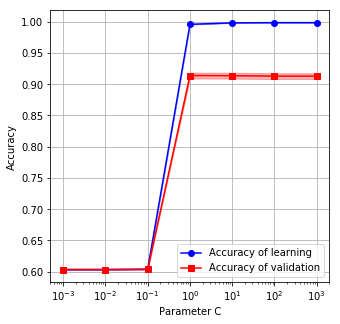

In [167]:
trans_name = 'tf'
plot_validation_curve(estimator=clone(best_rbf_svms[trans_name]), X=X_train_dict[trans_name], y=y_train, 
                      param_name='clf__C', param_range=np.logspace(-3, 3, 7), x_scale='log')

In [170]:
trans_name = 'tf'
rbf_svm_pipe = clone(best_rbf_svms[trans_name])
rbf_svm_pipe.set_params(**{'clf__C': 0.8})

rbf_svm_pipe.fit(X_train_dict[trans_name], y_train);

y_train_pred = rbf_svm_pipe.predict(X_train_dict[trans_name])
y_test_pred = rbf_svm_pipe.predict(X_test_dict[trans_name])
print('Tarining dataset: accuracy = %.3f' % accuracy_score(y_pred=y_train_pred, y_true=y_train))
print('Test dataset: accuracy = %.3f' % accuracy_score(y_pred=y_test_pred, y_true=y_test))

Tarining dataset: accuracy = 0.994
Test dataset: accuracy = 0.931


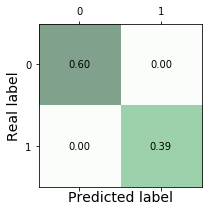

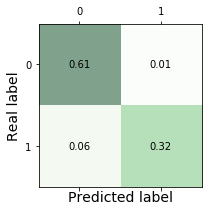

In [171]:
plot_confusion_matrix(y_train, y_train_pred)
plot_confusion_matrix(y_test, y_test_pred)

In [169]:
# trans_name = 'tf'
# plot_validation_curve(estimator=clone(best_rbf_svms[trans_name]), X=X_train_dict[trans_name], y=y_train, 
#                       param_name='clf__gamma', param_range=np.linspace(0.5, 3.5, 7), x_scale='linear')

In [174]:
trans_name = 'tf'
rbf_svm_pipe = clone(best_rbf_svms[trans_name])
rbf_svm_pipe.set_params(**{'clf__gamma': 2.})

rbf_svm_pipe.fit(X_train_dict[trans_name], y_train);

y_train_pred = rbf_svm_pipe.predict(X_train_dict[trans_name])
y_test_pred = rbf_svm_pipe.predict(X_test_dict[trans_name])
print('Tarining dataset: accuracy = %.3f' % accuracy_score(y_pred=y_train_pred, y_true=y_train))
print('Test dataset: accuracy = %.3f' % accuracy_score(y_pred=y_test_pred, y_true=y_test))

Tarining dataset: accuracy = 0.998
Test dataset: accuracy = 0.938


In [ ]:
# plot_learning_curve(estimator=clone(best_rbf_svms[trans_name]), X=X_train_dict[trans_name], y=y_train)

In [175]:
X_extended = np.r_[X_train, X_test]
y_extended = np.r_[y_train, y_test]
print(X_extended.shape, y_extended.shape)

(15970,) (15970,)


In [181]:
rbf_svm_pipe_extended = Pipeline([('transformers', clone(tf_pipe)),
                                  ('clf', clone(best_rbf_svms[trans_name]))])

extended_scores = cross_val_score(rbf_svm_pipe_extended, X_extended, y_extended, scoring='accuracy', 
                                  cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=10), n_jobs=-1)
print(np.round(extended_scores, 3))
print('Validation: accuracy = %.3f' % extended_scores.mean())

[0.934 0.932 0.932 0.94  0.926]
Validation: accuracy = 0.933


In [182]:
rbf_svm_pipe_extended.fit(X_extended, y_extended)
y_extended_pred = rbf_svm_pipe_extended.predict(X_extended)
print('Tarining dataset: accuracy = %.3f' % accuracy_score(y_pred=y_extended_pred, y_true=y_extended))

Tarining dataset: accuracy = 0.996


In [183]:
file_name = 'rbfsvm.p'
model = rbf_svm_pipe_extended
save_model(model, file_name)

In [194]:
importance = np.abs(rbf_svm_pipe_extended.named_steps['clf'].named_steps['clf'].dual_coef_.toarray()[0, :])
print_kbest(rbf_svm_pipe_extended.named_steps['transformers'], importance, 10)

Feature: gr damn                   Score:    2.253
Feature: hous emoticonhappyfac     Score:    2.253
Feature: have gubgivit             Score:    2.253
Feature: gonna start               Score:    2.253
Feature: heart oneexclamationmark  Score:    2.253
Feature: funni alway               Score:    2.253
Feature: fat ho                    Score:    2.253
Feature: i'm actual                Score:    2.253
Feature: hous                      Score:    2.253
Feature: becam                     Score:    2.253


In [195]:
sorted_features = get_sorted_features(rbf_svm_pipe_extended.named_steps['transformers'], importance)
print(sorted_features[:100])

['gr damn' 'hous emoticonhappyfac' 'have gubgivit' 'gonna start'
 'heart oneexclamationmark' 'funni alway' 'fat ho' "i'm actual" 'hous'
 'becam' 'epic win' 'abus' 'gonna lie' 'everyon thought' "i'v biggest"
 'gonna kick' 'have come' 'everybodi onedot' 'at onedot' 'girl is'
 'cri onedot' 'damn delici' 'ever use' 'circl squar' 'cl' 'hate haha'
 'charisma' 'bathtub onedot' 'good work' 'get is' 'desper ass' 'commerci'
 'haahah' 'ha oneexclamationmark' 'determin' 'get off'
 'great onequestionmark' 'good name' 'bbc' 'ass embrac' 'and impal'
 'florida fuck' 'hitler' 'hear hi' 'champ right' 'gangplank'
 'hi complaint' 'boot onequestionmark' 'hate game' 'famou person'
 'girl vip' 'at stomach' 'block perv' 'error oneexclamationmark' 'help do'
 'bigger dick' 'funni scari' 'are kid' 'hunt' 'hunni' 'hate most'
 'and final' 'hungri' 'cuz hi' 'help win' 'dumpster' 'draw blank' 'hummin'
 'fire wall' 'ground shame' 'equival' 'go thru' 'bestfriend' 'honest im'
 'go that' 'current onedot' 'gluten onedot'

In [196]:
k = 1000
file_name = 'rbfsvm' + str(k) + '.csv'
kbest_array = sorted_features[:k]
save_kbest(kbest_array, file_name)

#### Decision Tree

In [ ]:
# clf_name = 'dt'
# best_dts, dt_scores = search_best_clfs(clf_name, X_train_dict, X_test_dict, n_iter=3)

#### K-Nearest Neighbors

In [ ]:
# clf_name = 'knn'
# best_knns, knn_scores = search_best_clfs(clf_name, X_train_dict, X_test_dict, n_iter=3)

#### Naive Bayes

In [ ]:
# clf_name = 'nb'
# best_nbs, nb_scores = search_best_clfs(clf_name, X_train_dict, X_test_dict, n_iter=1)

#### Linear Discriminant Analysis

In [ ]:
# clf_name = 'lda'
# best_ldas, lda_scores = search_best_clfs(clf_name, X_train_dict, X_test_dict, n_iter=1)

#### Quadratic Discriminant Analysis

In [ ]:
# clf_name = 'qda'
# best_qdas, qda_scores = search_best_clfs(clf_name, X_train_dict, X_test_dict, n_iter=1)

### Ensembling

In [320]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
# from lightgbm import LGBMClassfier

from sklearn.model_selection import GridSearchCV

#### Bagging

In [334]:
bagging_clf = BaggingClassifier(max_samples=1000, max_features=0.4, n_estimators=100, 
                                bootstrap=True, bootstrap_features=False)

bagging_pipe = Pipeline([
    ('features', FeatureUnion([
            ('numerical_feats', FrequencyExtractor()),    
            ('text_feats', Pipeline([('preprocessor', TextPreprocessor(stopwords=IRRELEVANT_STOPWORDS, 
                                                                       process='stem')),
                                     ('vectorizer', CountVectorizer(token_pattern=token_pattern, min_df=2,
                                                                    ngram_range=(1, 2)))
                                    ]))
            ])),
    ('scaler', MaxAbsScaler()),
    ('clf', bagging_clf)
])

estimators_list = [DecisionTreeClassifier(max_depth=10),
                   LogisticRegression(C=1., penalty='l2'),
                   RandomForestClassifier(max_depth=10, max_features=0.5, n_estimators=10)]

param_grid = {'clf__base_estimator': estimators_list}

bagging_gs = GridSearchCV(estimator=bagging_pipe, param_grid=param_grid, 
                          cv=5, scoring='accuracy', 
                          n_jobs=-1, refit=True)

In [335]:
bagging_gs.fit(X_train, y_train);
bagging_gs.best_score_

0.6795554164057608

In [336]:
best_bagging_pipe = bagging_gs.best_estimator_

In [337]:
best_bagging_pipe.named_steps['clf']

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=0.4,
         max_samples=1000, n_estimators=100, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [338]:
y_train_pred = best_bagging_pipe.predict(X_train)
y_test_pred = best_bagging_pipe.predict(X_test)
print('Tarining dataset: accuracy = %.3f' % accuracy_score(y_pred=y_train_pred, y_true=y_train))
print('Test dataset: accuracy = %.3f' % accuracy_score(y_pred=y_test_pred, y_true=y_test))

Tarining dataset: accuracy = 0.718
Test dataset: accuracy = 0.709


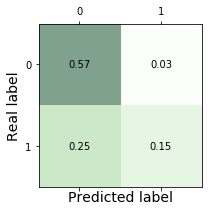

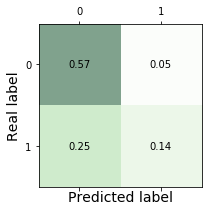

In [339]:
plot_confusion_matrix(y_train, y_train_pred)
plot_confusion_matrix(y_test, y_test_pred)

In [348]:
bagging_pipe = clone(best_bagging_pipe)
bagging_pipe.set_params(**{'clf__base_estimator__class_weight': {0: 1, 1: 1.4}})

bagging_pipe.fit(X_train, y_train);

y_train_pred = bagging_pipe.predict(X_train)
y_test_pred = bagging_pipe.predict(X_test)
print('Tarining dataset: accuracy = %.3f' % accuracy_score(y_pred=y_train_pred, y_true=y_train))
print('Test dataset: accuracy = %.3f' % accuracy_score(y_pred=y_test_pred, y_true=y_test))

Tarining dataset: accuracy = 0.746
Test dataset: accuracy = 0.722


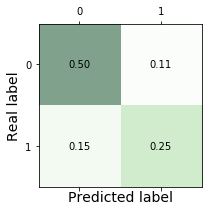

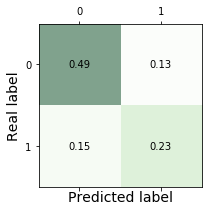

In [349]:
plot_confusion_matrix(y_train, y_train_pred)
plot_confusion_matrix(y_test, y_test_pred)

In [350]:
X_extended = np.r_[X_train, X_test]
y_extended = np.r_[y_train, y_test]

In [ ]:
bagging_pipe_extended = clone(bagging_pipe)
bagging_pipe_extended.fit(X_extended, y_extended);

In [ ]:
y_train_pred = bagging_pipe_extended.predict(X_extended)

In [353]:
print('Tarining dataset: accuracy = %.3f' % accuracy_score(y_pred=y_train_pred, y_true=y_extended))

Tarining dataset: accuracy = 0.749


In [355]:
file_name = 'baggingtree.p'
model = bagging_pipe_extended
save_model(model, file_name)

#### Voting

In [357]:
estimators_list = [('dt', DecisionTreeClassifier(max_depth=10)),
                   ('lr', LogisticRegression(C=1., penalty='l2')),
                   ('rf', RandomForestClassifier(max_depth=10, max_features=0.5, n_estimators=10))]

voting_clf = VotingClassifier(estimators=estimators_list)

voting_pipe = Pipeline([
    ('features', FeatureUnion([
            ('numerical_feats', FrequencyExtractor()),    
            ('text_feats', Pipeline([('preprocessor', TextPreprocessor(stopwords=IRRELEVANT_STOPWORDS, 
                                                                       process='stem')),
                                     ('vectorizer', CountVectorizer(token_pattern=token_pattern, min_df=2,
                                                                    ngram_range=(1, 2)))
                                    ]))
            ])),
    ('scaler', MaxAbsScaler()),
    ('clf', voting_clf)
])

param_grid = {'clf__voting': ['hard', 'soft']}

voting_gs = GridSearchCV(estimator=voting_pipe, param_grid=param_grid, 
                          cv=5, scoring='accuracy', 
                          n_jobs=-1, refit=True)

In [359]:
# voting_gs.fit(X_train, y_train);
# voting_gs.best_score_

#### Boosting

In [381]:
?XGBClassifier

In [425]:
xgb_clf = XGBClassifier()

xgb_pipe = Pipeline([
    ('features', FeatureUnion([
            ('numerical_feats', FrequencyExtractor()),    
            ('text_feats', Pipeline([('preprocessor', TextPreprocessor(stopwords=IRRELEVANT_STOPWORDS, 
                                                                       process='stem')),
                                     ('vectorizer', CountVectorizer(token_pattern=token_pattern, min_df=2,
                                                                    ngram_range=(1, 2)))
                                    ]))
            ])),
    ('scaler', MaxAbsScaler()),
    ('clf', xgb_clf)
])

param_dist = {'clf__learning_rate': uniform(0.001, 2 - 0.001),
              'clf__max_depth': randint(5, 20),
              'clf__reg_lambda': uniform(0, 2),
              'clf__gamma': uniform(0, 0.5),
              'clf__colsample_bytree': uniform(0.5, 0.5),
              'clf__subsample': uniform(0.5, 0.5),
              'clf__min_child_weight': randint(1, 11),
              'clf__n_estimators': randint(50, 400),
             }

xgb_gs = RandomizedSearchCV(estimator=xgb_pipe, param_distributions=param_dist, 
                            cv=5, scoring='accuracy', n_iter=10,
                            n_jobs=-1, refit=True)

In [426]:
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [427]:
xgb_gs.fit(X_train, y_train);

In [428]:
xgb_gs.best_score_

0.8443174702567313

In [429]:
best_xgb_pipe = xgb_gs.best_estimator_
best_xgb_pipe.named_steps['clf'].get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 0.7484176463626866,
 'gamma': 0.4029680740462477,
 'learning_rate': 0.5272511180392236,
 'max_delta_step': 0,
 'max_depth': 17,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 112,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1.957313823194363,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': True,
 'subsample': 0.967432237442374}

In [430]:
y_train_pred = best_xgb_pipe.predict(X_train)
y_test_pred = best_xgb_pipe.predict(X_test)
print('Tarining dataset: accuracy = %.3f' % accuracy_score(y_pred=y_train_pred, y_true=y_train))
print('Test dataset: accuracy = %.3f' % accuracy_score(y_pred=y_test_pred, y_true=y_test))

Tarining dataset: accuracy = 0.997
Test dataset: accuracy = 0.886


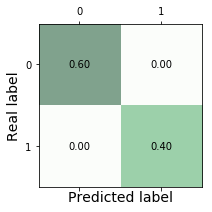

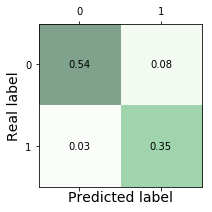

In [431]:
plot_confusion_matrix(y_train, y_train_pred)
plot_confusion_matrix(y_test, y_test_pred)

In [375]:
# plot_validation_curve(estimator=clone(xgb_pipe), X=X_train, y=y_train, 
#                       param_name='clf__learning_rate', param_range=np.linspace(0.01, 3, 7), x_scale='linear')

In [432]:
xgb_pipe_extended = clone(best_xgb_pipe)
xgb_pipe_extended.fit(X_extended, y_extended);
y_extended_pred = xgb_pipe_extended.predict(X_extended)
print('Tarining dataset: accuracy = %.3f' % accuracy_score(y_pred=y_extended_pred, y_true=y_extended))

Tarining dataset: accuracy = 0.997


In [433]:
file_name = 'xgb.p'
model = xgb_pipe_extended
save_model(model, file_name)

### Recurrent Neural Network

In [8]:
from mytextpreprocessing import WordToIndexTransformer

from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, SimpleRNN, LSTM, Bidirectional
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.utils import print_summary

In [10]:
preprocessor = TextPreprocessor(stopwords=IRRELEVANT_STOPWORDS, process='stem')
wordToIndex = WordToIndexTransformer(preprocessor)

In [11]:
X_rnn_train = wordToIndex.fit_transform(X_train)
X_rnn_test = wordToIndex.transform(X_test)

In [12]:
max_features = wordToIndex.unique_words_no + 1
maxlen = wordToIndex.maxlen
embedding_dims = 32
print(max_features, maxlen)

10775 280


In [13]:
X_rnn_train.shape, X_rnn_test.shape

((12776, 280), (3194, 280))

In [14]:
model = Sequential()
model.add(Embedding(max_features, embedding_dims, input_length=maxlen))
# model.add(LSTM(100, return_sequences=False))
model.add(SimpleRNN(100, return_sequences=False))
model.add(Dropout(0.4))
model.add(Dense(32, activation='tanh'))
# model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.002)))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

In [15]:
print_summary(model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 280, 32)           344800    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 100)               13300     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                3232      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 361,365
Trainable params: 361,365
Non-trainable params: 0
_________________________________________________________________


In [20]:
early_stopping = EarlyStopping(patience=3)
model.fit(X_rnn_train, y_train, batch_size=32, epochs=50, callbacks=[early_stopping], validation_split=0.4)

Train on 7665 samples, validate on 5111 samples
Epoch 1/50
7665/7665 [==============================] - 41s 5ms/step - loss: 0.0503 - acc: 0.9826 - val_loss: 1.0221 - val_acc: 0.7781
Epoch 2/50
7665/7665 [==============================] - 37s 5ms/step - loss: 0.0364 - acc: 0.9883 - val_loss: 1.1740 - val_acc: 0.7629
Epoch 3/50
7665/7665 [==============================] - 36s 5ms/step - loss: 0.0337 - acc: 0.9901 - val_loss: 1.1210 - val_acc: 0.7537
Epoch 4/50
7665/7665 [==============================] - 42s 5ms/step - loss: 0.5992 - acc: 0.6600 - val_loss: 0.6365 - val_acc: 0.6239
Epoch 5/50
7665/7665 [==============================] - 53s 7ms/step - loss: 0.6428 - acc: 0.6287 - val_loss: 0.6418 - val_acc: 0.5993
Epoch 6/50
7665/7665 [==============================] - 43s 6ms/step - loss: 0.5870 - acc: 0.6802 - val_loss: 0.5838 - val_acc: 0.7151
Epoch 7/50
7665/7665 [==============================] - 41s 5ms/step - loss: 0.3728 - acc: 0.8360 - val_loss: 0.6393 - val_acc: 0.7668
Epoch 8

In [21]:
train_accuracy = model.evaluate(X_rnn_train, y_train, verbose=0)
test_accuracy = model.evaluate(X_rnn_test, y_test, verbose=0)

print('Tarining dataset:\nloss = %.3f\naccuracy = %.3f' % tuple(train_accuracy))
print('Test dataset:\nloss = %.3f\naccuracy = %.3f' % tuple(test_accuracy))

Tarining dataset:
loss = 0.357
accuracy = 0.883
Test dataset:
loss = 0.741
accuracy = 0.752


In [27]:
# file_name = 'rnn.p'
# save_model(model, file_name)